# Requirements

In [3]:
import pandas as pd 
import wandb

def load_metrics_from_wandb(proj_name, dataset_name: str = ""):
    if dataset_name != "":
        dataset_name += "_"

    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run[dataset_name+"test_score"])
        accuracy.append(run[dataset_name+"test_accuracy"])
    
    return AUC_score, accuracy


def load_MILC_metrics_from_wandb(proj_name, dataset_name: str = ""):
    if dataset_name != "":
        dataset_name += "_"

    # I named test logs as train, so this is a lazy fix
    api = wandb.Api()
    # Project is specified by <entity/project-name>
    runs = api.runs(f"pavalipopov/{proj_name}")

    summary_list, config_list, name_list = [], [], []
    for run in runs: 
        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files 
        summary_list.append(run.summary._json_dict)

        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        config_list.append(
            {k: v for k,v in run.config.items()
            if not k.startswith('_')})

        # .name is the human-readable name of the run.
        name_list.append(run.name)

    runs_df = pd.DataFrame({
        "summary": summary_list,
        "config": config_list,
        "name": name_list
        })

    AUC_score = []
    accuracy = []

    for run in runs_df["summary"]:
        AUC_score.append(run[dataset_name+"train_score"])
        accuracy.append(run[dataset_name+"train_accuracy"])
    
    return AUC_score, accuracy


def pd_load_metrics_from_wandb(proj_name, extra_dataset: str = "", model_name: str = None, dataset_name: str = None):
    project_config = proj_name.split('-')

    model = project_config[2].upper().replace('_', ' ')
    dataset = project_config[3].upper().replace('_', ' ')

    if model == "TRANSFORMER":
        model = "Transformer"
    if model == "NEW ATTENTION MLP":
        model = "Attention MLP"

    if model == "MILC":
        auc, acc = load_MILC_metrics_from_wandb(proj_name, extra_dataset)
    else:
        auc, acc = load_metrics_from_wandb(proj_name, extra_dataset)
        
    if extra_dataset != "":
        dataset = dataset[0] + "x" + extra_dataset[0].upper()

    if model_name is not None:
        model = model_name

    if dataset_name is not None:
        dataset = dataset_name

    model = [model] * len(auc)
    dataset = [dataset] * len(auc)

    return pd.DataFrame(
        {
            "AUC": auc,
            "Accuracy": acc,
            "Model": model,
            "Dataset": dataset,
        }
    )

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# sns.set(font_scale = 2)
# sns.set(rc={'figure.figsize':(18,9)})
# так масштаб приятнее
# sns.set_theme(style="whitegrid", font_scale = 3, rc={'figure.figsize':(18,9)})

sns.set_theme(
    style="whitegrid", 
    font_scale = 2, 
    rc={'figure.figsize':(18,9)}
)

def plot_box_plots(data, data_names, title, y_title):
    plot = sns.boxplot(
        data=data,
        showfliers = True,
    )
    plt.title(title)
    plot.set_xticklabels(data_names)
    plot.set(ylabel=y_title)

# Examples

## Import data from WandB

In [23]:
# project name: experiment-mlp-ukb
mlp_ukb_AUC, mlp_ukb_accuracy = load_metrics_from_wandb("experiment-mlp-ukb")

## Import data from CSV

In [ ]:
import csv
mlp_ukb_AUC = []
mlp_ukb_accyracy = []
with open('/path_to_csv.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        mlp_ukb_AUC.append(float(row[N]))
        mlp_ukb_accuracy.append(float(row[M]))

## Plot data

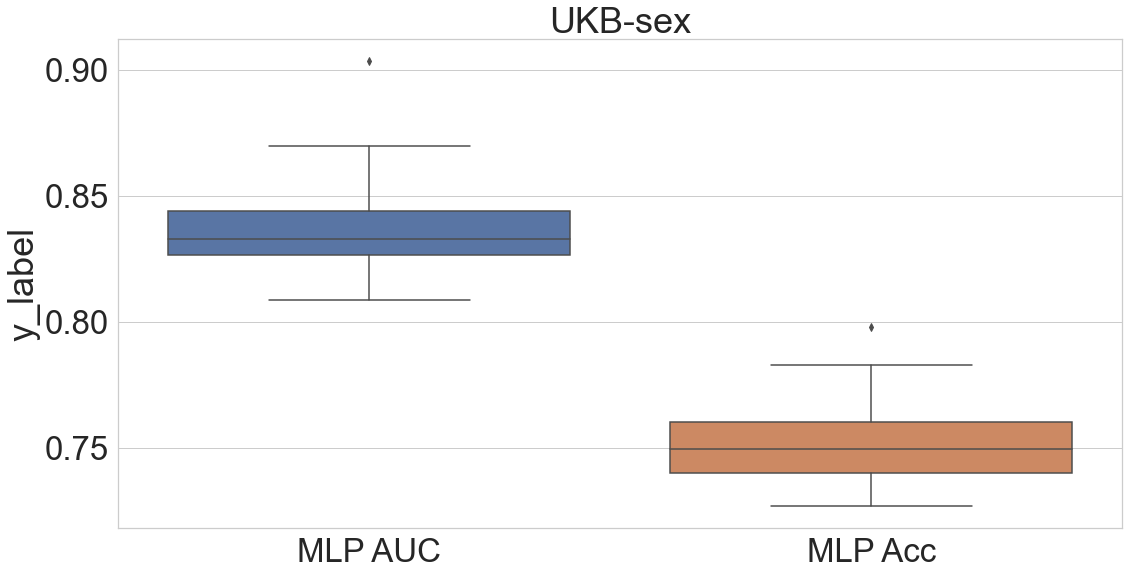

In [37]:
data = [mlp_ukb_AUC, mlp_ukb_accuracy]
data_names = ["MLP AUC", "MLP Acc"]
plot_box_plots(data, data_names, "UKB-sex", "y_label")


# Testing different MLP models on FBIRN

## MLP architectures

In [39]:
# MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-mlp-fbirn")

# No Residual block MLP

nores_mlp_fbirn_AUC, nores_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-nores_mlp-fbirn")

# Transposed MLP

trans_mlp_fbirn_AUC, trans_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-trans_mlp-fbirn")

# no ensemble MLP

noens_mlp_fbirn_AUC, noens_mlp_fbirn_accuracy = load_metrics_from_wandb("experiment-noens_mlp-fbirn")

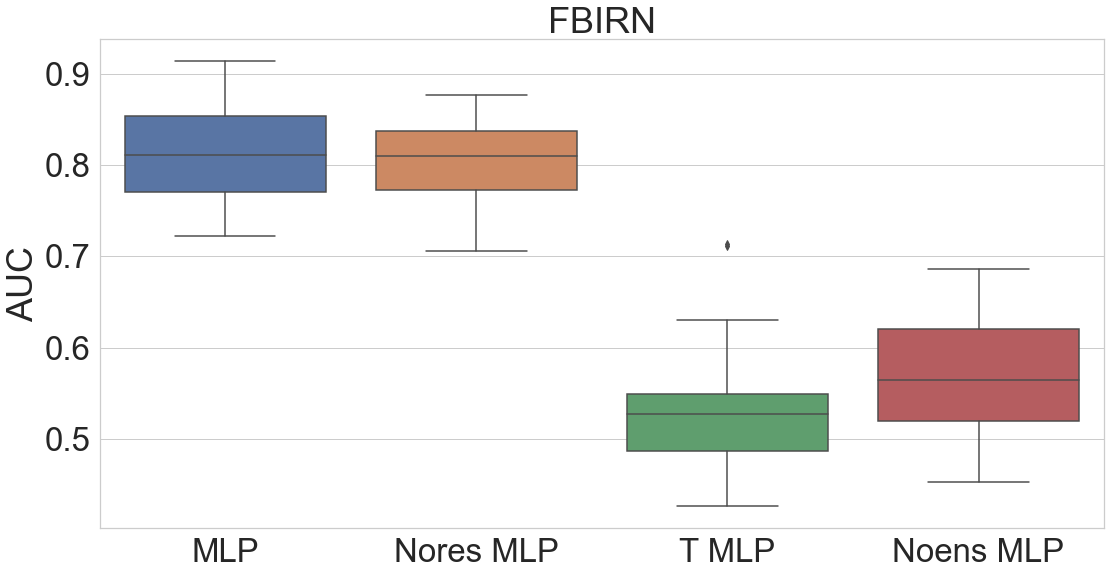

In [42]:
auc_data = [mlp_fbirn_AUC, nores_mlp_fbirn_AUC, trans_mlp_fbirn_AUC, noens_mlp_fbirn_AUC]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

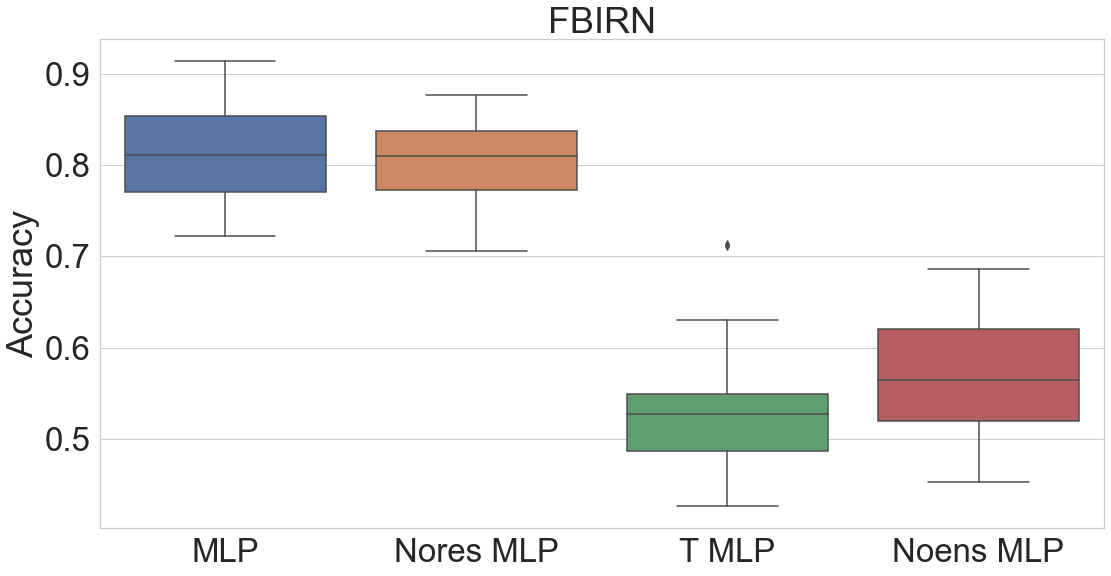

In [43]:
acc_data = [mlp_fbirn_accuracy, nores_mlp_fbirn_accuracy, trans_mlp_fbirn_accuracy, noens_mlp_fbirn_accuracy]
data_names = ["MLP", "Nores MLP", "T MLP", "Noens MLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "Accuracy")

## Deep, wide and attention MLP

In [28]:
# Simple MLP

mlp_fbirn_AUC, mlp_fbirn_accuracy = load_metrics_from_wandb("220817.031422-experiment-mlp-fbirn")

# Deep MLP

deep_mlp_fbirn_AUC, deep_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.020923-experiment-deep_mlp-fbirn")

# Wide MLP

wide_mlp_fbirn_AUC, wide_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.000759-tune-wide_mlp-fbirn")

# old attention MLP

old_attn_mlp_fbirn_AUC, old_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.044951-experiment-attention_mlp-fbirn")

# new attention MLP

new_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220817.041043-experiment-new_attention_mlp-fbirn")

# newest attention MLP

newest_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_accuracy = load_metrics_from_wandb("220820.010149-experiment-newest_attention_mlp-fbirn")

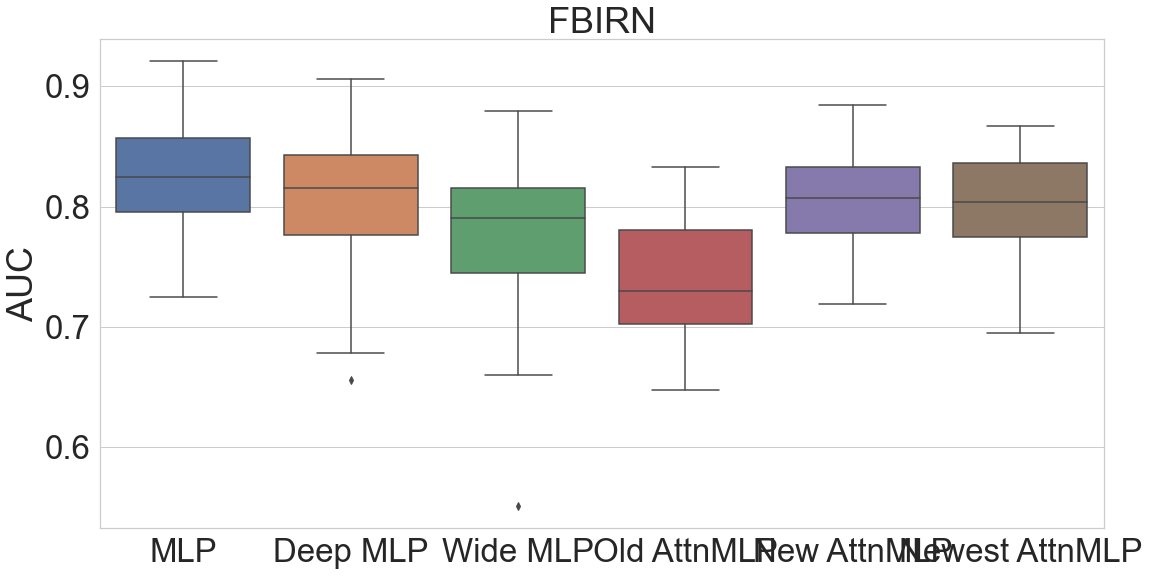

In [32]:
auc_data = [mlp_fbirn_AUC, deep_mlp_fbirn_AUC, wide_mlp_fbirn_AUC, old_attn_mlp_fbirn_AUC, new_attn_mlp_fbirn_AUC, newest_attn_mlp_fbirn_AUC]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(auc_data, data_names, "FBIRN", "AUC")

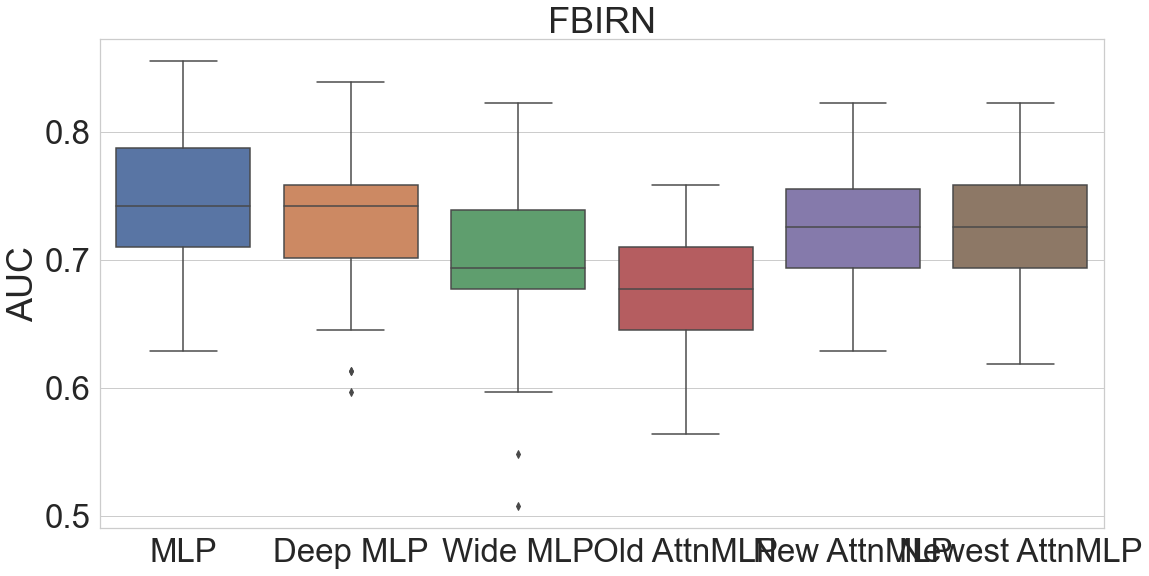

In [33]:
acc_data = [mlp_fbirn_accuracy, deep_mlp_fbirn_accuracy, wide_mlp_fbirn_accuracy, old_attn_mlp_fbirn_accuracy, new_attn_mlp_fbirn_accuracy, newest_attn_mlp_fbirn_accuracy]
data_names = ["MLP", "Deep MLP", "Wide MLP", "Old AttnMLP", "New AttnMLP", "Newest AttnMLP"]
plot_box_plots(acc_data, data_names, "FBIRN", "AUC")

# Experiments

#### All together

In [14]:
proj_names = [
    #OASIS
    "220811.052827-experiment-mlp-oasis",
    "220817.022010-experiment-new_attention_mlp-oasis",
    "new-experiment-milc-oasis",
    "NPT-experiment-milc-oasis",
    "220817.085028-experiment-lstm-oasis",
    "220823.054741-experiment-another_lstm-oasis",
    "220825.183225-experiment-transformer-oasis",
    #ABIDE
    "220811.190848-experiment-mlp-abide",
    "220817.033648-experiment-new_attention_mlp-abide",
    "new-experiment-milc-abide",
    "220817.131942-experiment-lstm-abide",
    "220823.122916-experiment-another_lstm-abide",
    "220826.154213-experiment-transformer-abide",
    #Abide 869
    "220811.221744-experiment-mlp-abide_869",
    "220817.052433-experiment-new_attention_mlp-abide_869",
    "new-experiment-milc-abide_869",
    "220820.205431-experiment-lstm-abide_869",
    "220824.025849-experiment-another_lstm-abide_869",
    "220826.214154-experiment-transformer-abide_869",
    #FBIRN
    "220817.031422-experiment-mlp-fbirn",
    "220817.041043-experiment-new_attention_mlp-fbirn",
    "newer-experiment-milc-fbirn",
    "220817.225007-experiment-lstm-fbirn",
    "220823.220212-experiment-another_lstm-fbirn",
    "220826.185919-experiment-transformer-fbirn",
    "noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip",
    "deep_noah-experiment-deep_noah_lstm-fbirn-tests-cobre_bsnip",
    "mean_transformer-experiment-mean_transformer-fbirn-tests-cobre_bsnip"
    #COBRE
    "220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip",
    "220830.025754-experiment-new_attention_mlp-cobre",
    "newer-experiment-milc-cobre",
    "220830.080927-experiment-lstm-cobre",
    "220831.070739-experiment-another_lstm-cobre",
    "220831.224232-experiment-transformer-cobre",
    #BSNIP
    "220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre",
    "220830.041453-experiment-new_attention_mlp-bsnip",
    "newer-experiment-milc-bsnip",
    "220831.003802-experiment-lstm-bsnip",
    "220831.123732-experiment-another_lstm-bsnip",
    "220901.064229-experiment-transformer-bsnip",
]

all_data = [pd_load_metrics_from_wandb(x) for x in proj_names]
all_data = pd.concat(all_data)

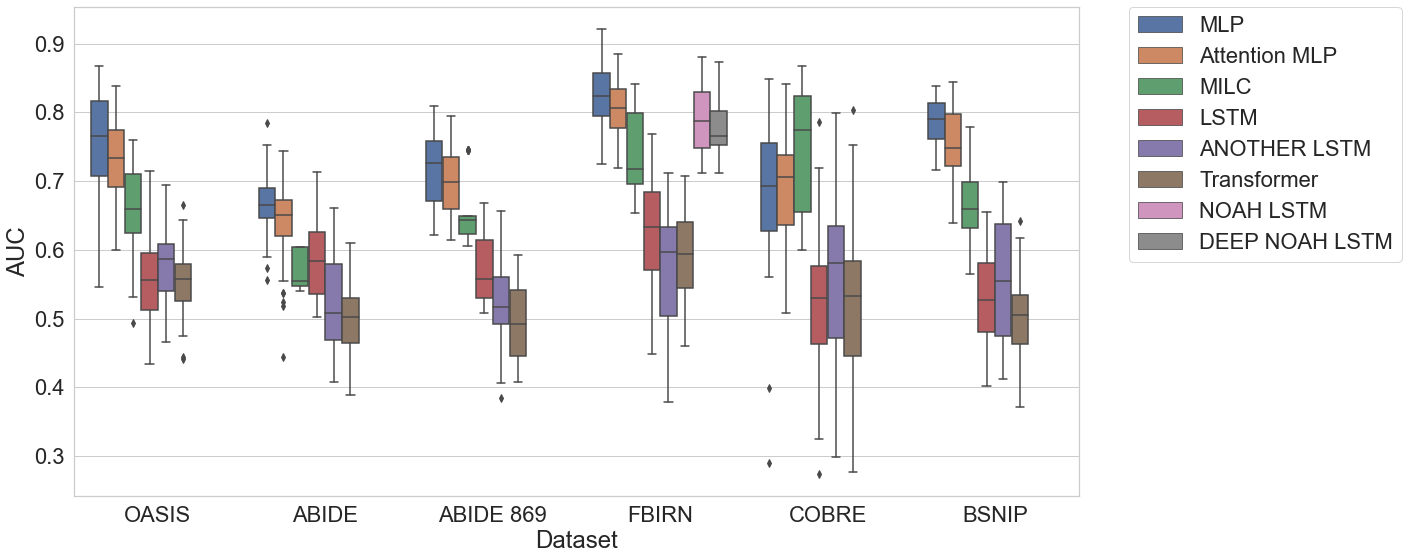

In [15]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/all_auc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

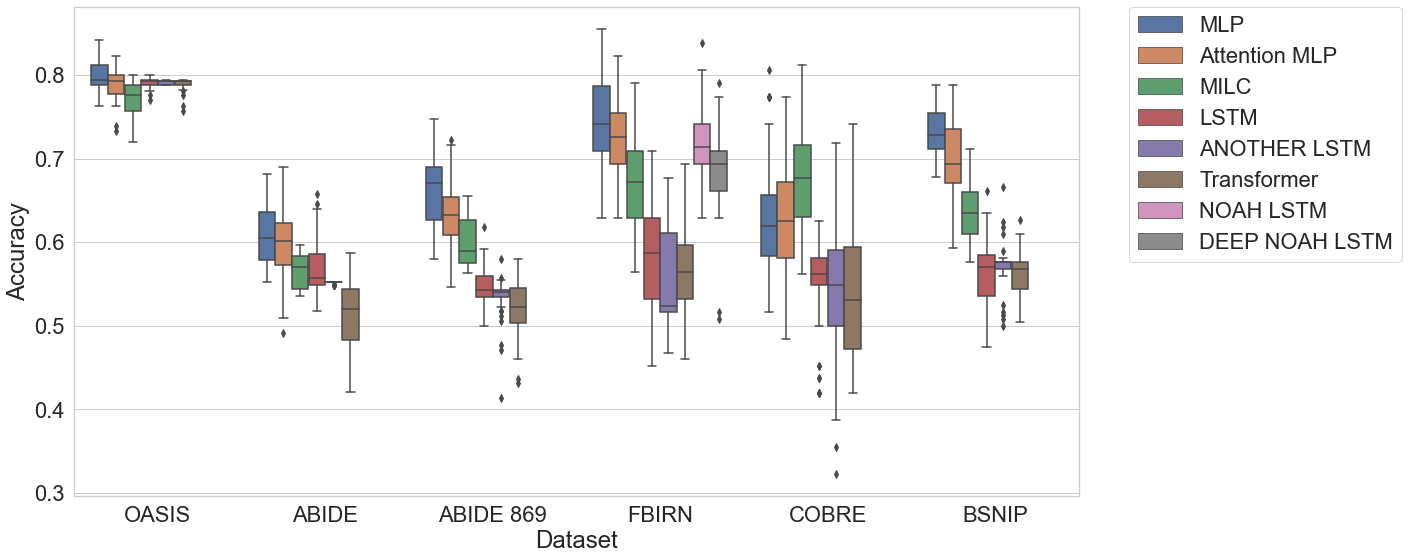

In [16]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/all_acc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

# FBIRN only

In [19]:
proj_names = [
    #FBIRN
    "220817.031422-experiment-mlp-fbirn",
    "220817.041043-experiment-new_attention_mlp-fbirn",
    "newer-experiment-milc-fbirn",
    "220817.225007-experiment-lstm-fbirn",
    "220823.220212-experiment-another_lstm-fbirn",
    "220826.185919-experiment-transformer-fbirn",
    "noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip",
    "deep_noah-experiment-deep_noah_lstm-fbirn-tests-cobre_bsnip",
    "mean_transformer-experiment-mean_transformer-fbirn-tests-cobre_bsnip",
    "last_noah-experiment-last_noah_lstm-fbirn-tests-cobre_bsnip"
]

all_data = [pd_load_metrics_from_wandb(x) for x in proj_names]
all_data = pd.concat(all_data)

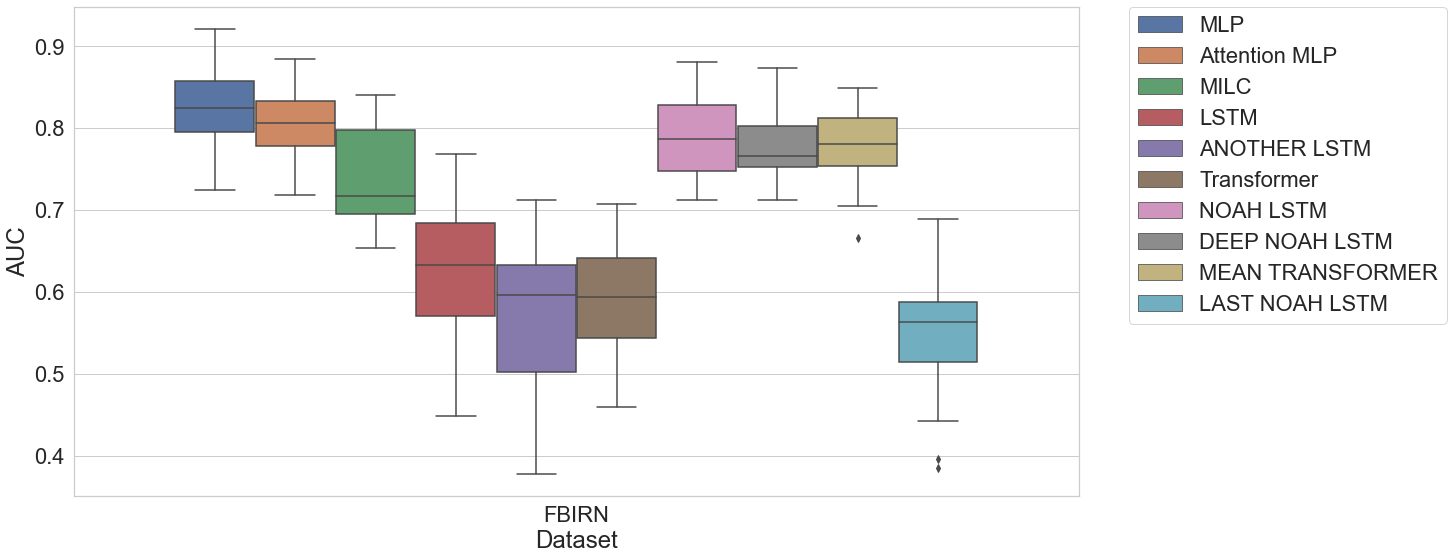

In [20]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=all_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

#### MLP-MILC Cross-dataset together

In [14]:
proj_names = [
    # MLP
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", ""),
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "bsnip"),
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "cobre"),
    #
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", ""),
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", "fbirn"),
    ("220827.012730-experiment-mlp-bsnip-tests-fbirn_cobre", "cobre"),
    #
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", ""),
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", "fbirn"),
    ("220827.014957-experiment-mlp-cobre-tests-fbirn_bsnip", "bsnip"),
    # # MILC
    # ("new-experiment-milc-fbirn", ""),
    # ("new-experiment-milc-fbirn", "bsnip"),
    # ("new-experiment-milc-fbirn", "cobre"),
    # #
    # ("new-experiment-milc-bsnip", ""),
    # ("new-experiment-milc-bsnip", "fbirn"),
    # ("new-experiment-milc-bsnip", "cobre"),
    # #
    # ("new-experiment-milc-cobre", ""),
    # ("new-experiment-milc-cobre", "fbirn"),
    # ("new-experiment-milc-cobre", "bsnip"),
    # Fixed MILC
    ("newer-experiment-milc-fbirn", ""),
    ("newer-experiment-milc-fbirn", "bsnip"),
    ("newer-experiment-milc-fbirn", "cobre"),
    #
    ("newer-experiment-milc-bsnip", ""),
    ("newer-experiment-milc-bsnip", "fbirn"),
    ("newer-experiment-milc-bsnip", "cobre"),
    #
    ("newer-experiment-milc-cobre", ""),
    ("newer-experiment-milc-cobre", "fbirn"),
    ("newer-experiment-milc-cobre", "bsnip"),
    # # New Fixed MILC
    # ("newest-experiment-milc-fbirn", ""),
    # ("newest-experiment-milc-fbirn", "bsnip"),
    # ("newest-experiment-milc-fbirn", "cobre"),
    # #
    # ("newest-experiment-milc-bsnip", ""),
    # ("newest-experiment-milc-bsnip", "fbirn"),
    # ("newest-experiment-milc-bsnip", "cobre"),
    # #
    # ("newest-experiment-milc-cobre", ""),
    # ("newest-experiment-milc-cobre", "fbirn"),
    # ("newest-experiment-milc-cobre", "bsnip"),
]
cross_data = [pd_load_metrics_from_wandb(x[0], x[1]) for x in proj_names]

proj_names = [
    # NPT MILC
    ("NPT-experiment-milc-fbirn", "", "NPT MILC"),
    ("NPT-experiment-milc-fbirn", "bsnip", "NPT MILC"),
    ("NPT-experiment-milc-fbirn", "cobre", "NPT MILC"),
    #
    ("NPT-experiment-milc-bsnip", "", "NPT MILC"),
    ("NPT-experiment-milc-bsnip", "fbirn", "NPT MILC"),
    ("NPT-experiment-milc-bsnip", "cobre", "NPT MILC"),
    #
    ("NPT-experiment-milc-cobre", "", "NPT MILC"),
    ("NPT-experiment-milc-cobre", "fbirn", "NPT MILC"),
    ("NPT-experiment-milc-cobre", "bsnip", "NPT MILC"),
]
cross_data.extend([pd_load_metrics_from_wandb(x[0], x[1], model_name=x[2]) for x in proj_names])
cross_data = pd.concat(cross_data)

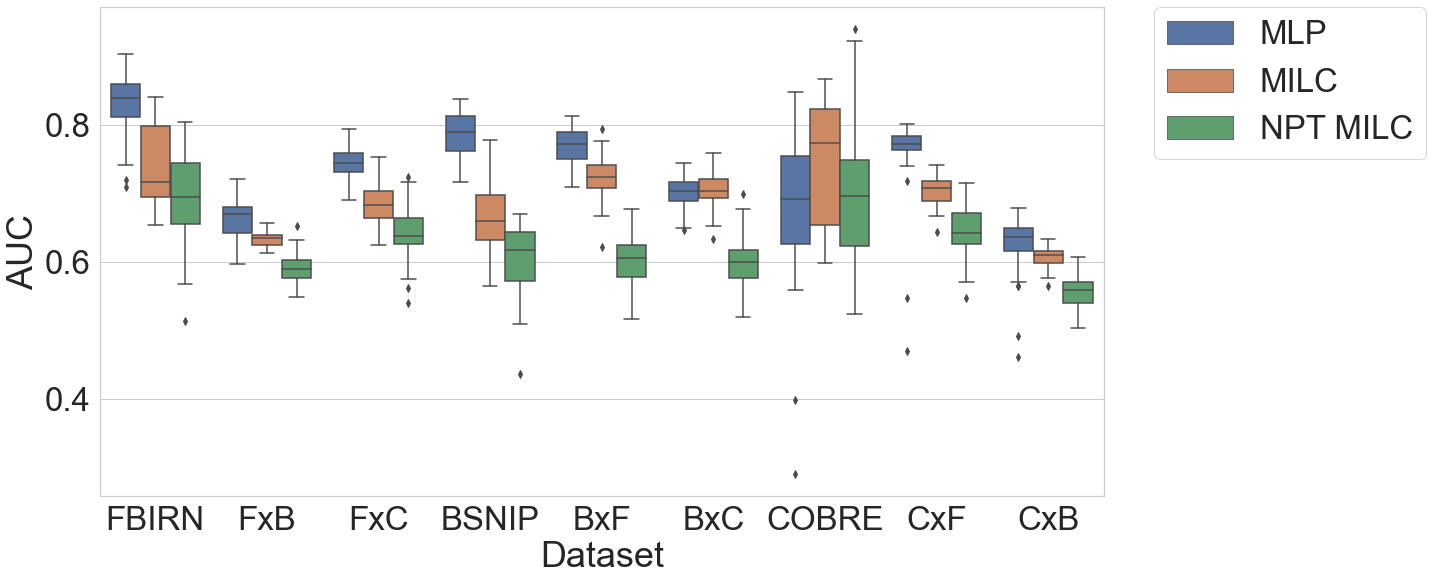

In [15]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=cross_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/cross_auc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

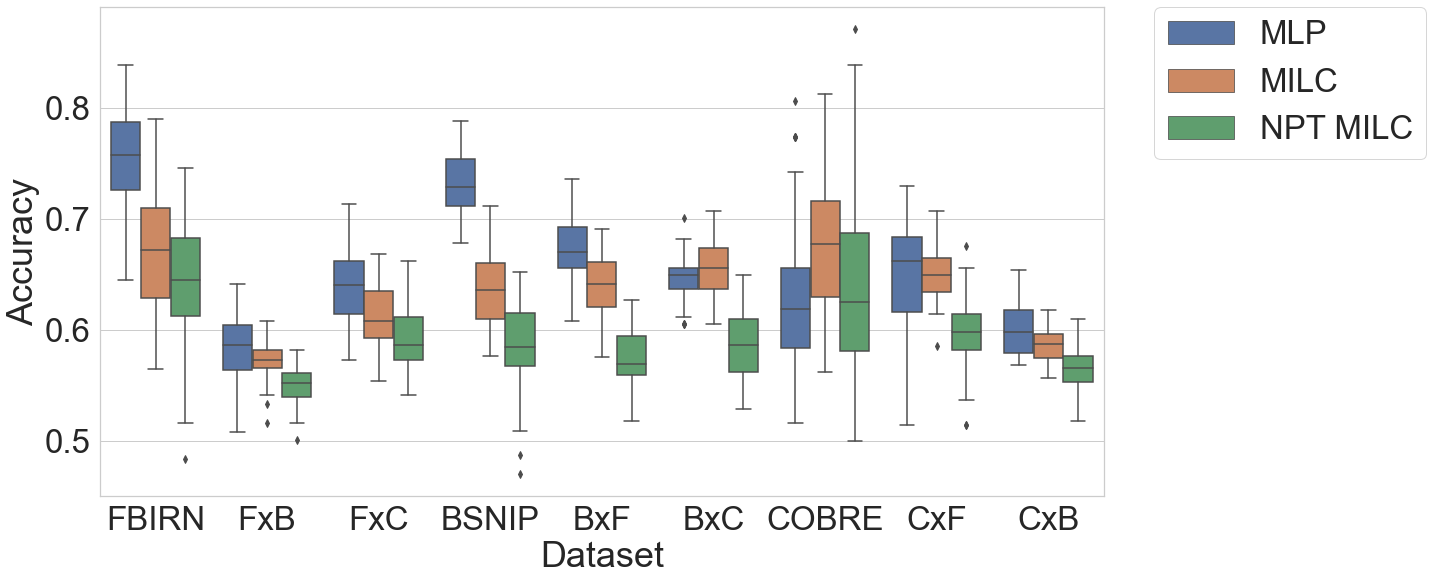

In [16]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=cross_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.savefig(
    "./images/cross_acc.png",
    format="png",
    dpi=300,
    bbox_inches='tight',
)

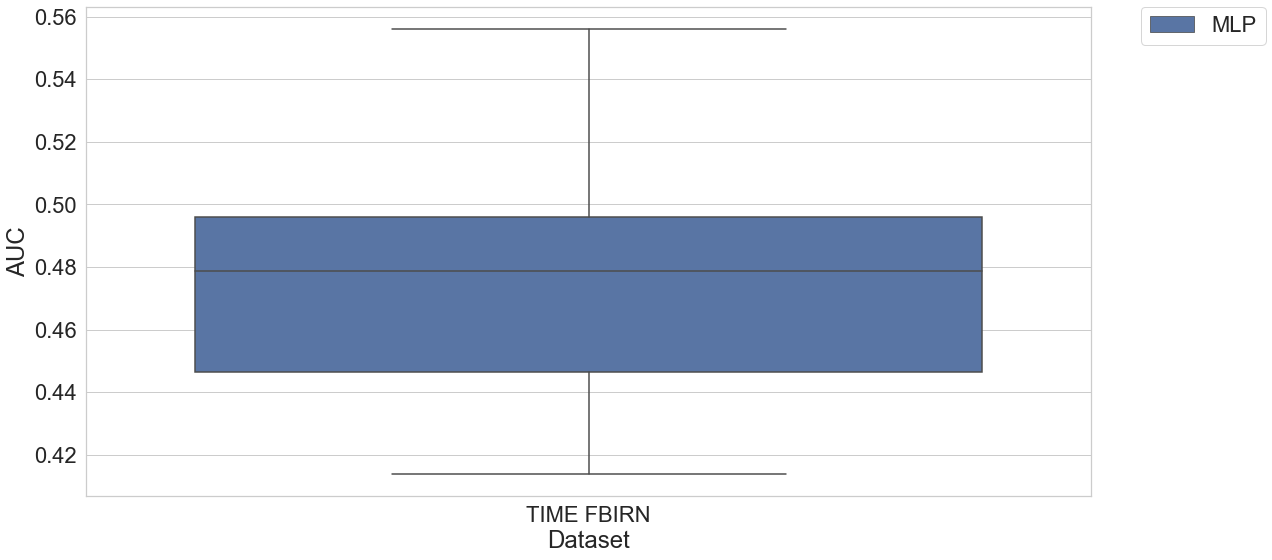

In [6]:

data = pd_load_metrics_from_wandb("220930.164853-experiment-mlp-time_fbirn")
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

In [9]:
path = [
    ("220827.011216-experiment-mlp-fbirn-tests-cobre_bsnip_abide", "FBIRN"),
    ("220817.225007-experiment-lstm-fbirn", "FBIRN"),
    ("noah-experiment-noah_lstm-fbirn-tests-cobre_bsnip", "FBIRN")

]
scale_data = [pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path]

path = [
    ("final-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Time Scaled FBIRN"),
    ("final-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Time Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

path = [
    ("channel-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Channel Scaled FBIRN"),
    ("channel-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Channel Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

path = [
    ("tm-experiment-mlp-scaled_fbirn-tests-cobre_bsnip", "Time-channel Scaled FBIRN"),
    ("tm-experiment-lstm-scaled_fbirn-tests-cobre_bsnip", "Time-channel Scaled FBIRN"),
]
scale_data.extend([pd_load_metrics_from_wandb(x[0], dataset_name=x[1]) for x in path])

scale_data = pd.concat(scale_data)

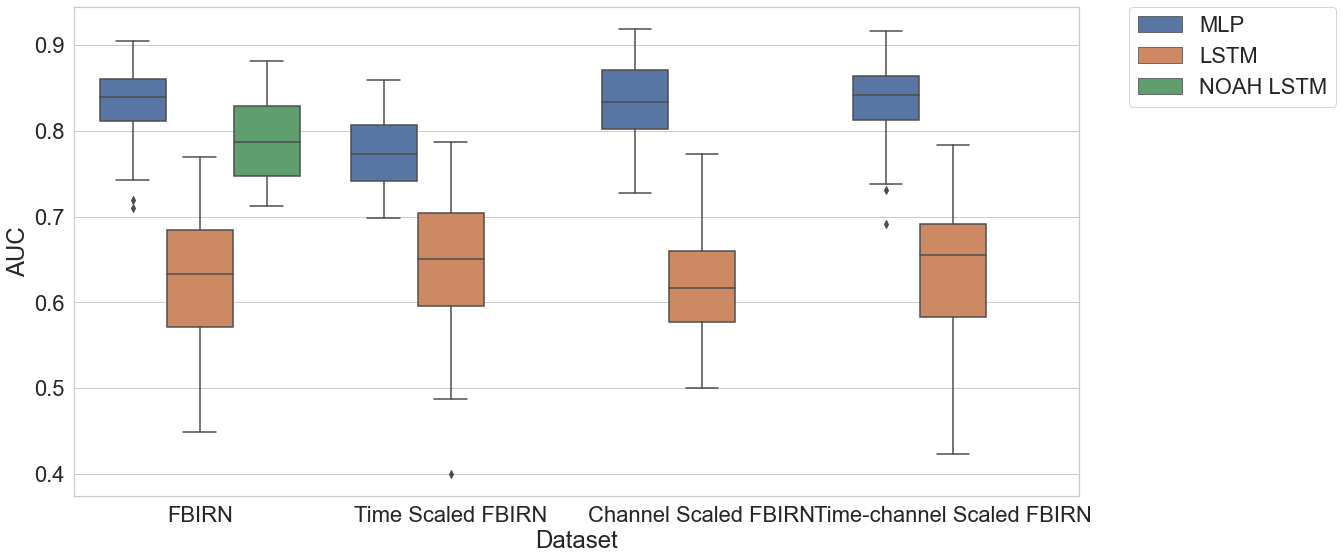

In [10]:
sns.boxplot(x="Dataset", y="AUC",
            hue="Model",
            data=scale_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

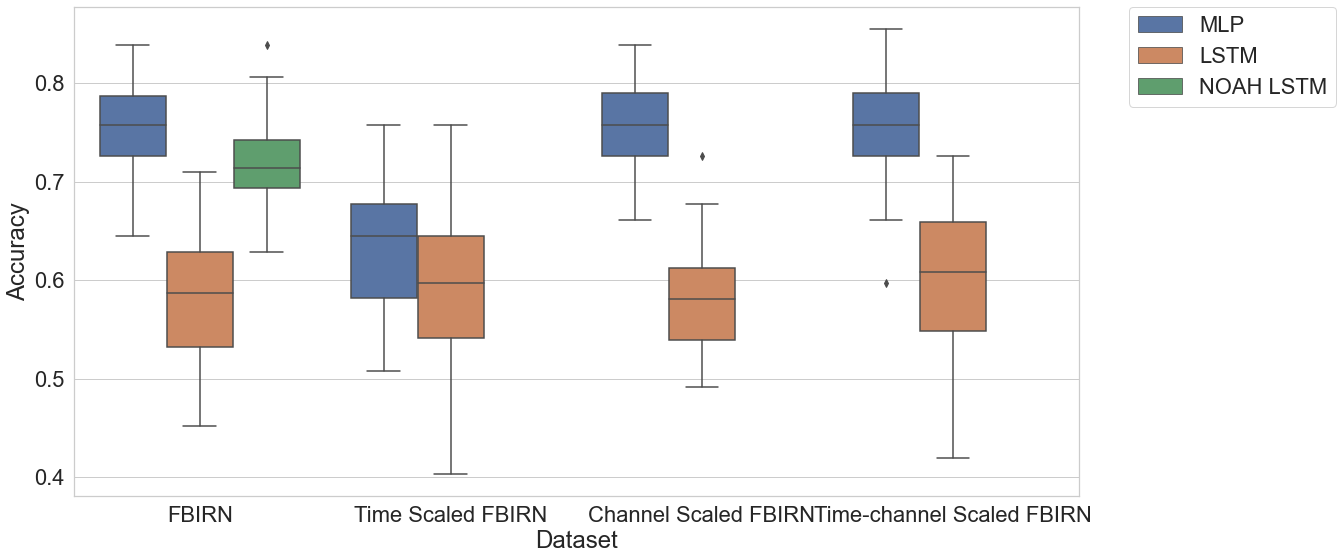

In [11]:
sns.boxplot(x="Dataset", y="Accuracy",
            hue="Model",
            data=scale_data)
# sns.despine(offset=10, trim=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

plt.show()

In [97]:
import os
import csv
import argparse
import json

import pandas as pd
from apto.utils.misc import boolean_flag
from apto.utils.report import get_classification_report
import numpy as np
import optuna
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm

from animus import EarlyStoppingCallback, IExperiment
from animus.torch.callbacks import TorchCheckpointerCallback
import wandb

import path
import h5py

DATA_ROOT = path.Path("/Users/pavelpopov/mlp_project/assets/data")

def load_FBIRN(
    dataset_path: str = DATA_ROOT.joinpath("fbirn/FBIRN_AllData.h5"),
    indices_path: str = DATA_ROOT.joinpath("fbirn/correct_indices_GSP.csv"),
    labels_path: str = DATA_ROOT.joinpath("fbirn/labels_FBIRN_new.csv"),
):
    """
    Return FBIRN data

    Input:
    dataset_path: str = DATA_ROOT.joinpath("fbirn/FBIRN_AllData.h5")
    - path to the dataset
    indices_path: str = DATA_ROOT.joinpath("fbirn/correct_indices_GSP.csv")
    - path to correct indices/components
    labels_path: str = DATA_ROOT.joinpath("fbirn/labels_FBIRN_new.csv")
    - path to labels

    Output:
    features, labels
    """

    # get data
    hf = h5py.File(dataset_path, "r")
    data = hf.get("FBIRN_dataset")
    data = np.array(data)
    # print(data.shape)
    # >>> (311, 14000)

    # reshape data
    num_subjects = data.shape[0]
    num_components = 100
    data = data.reshape(num_subjects, num_components, -1)
    # 311 - sessions - data.shape[0]
    # 100 - components - data.shape[1]
    # 140 - time points - data.shape[2]

    # get correct indices/components
    indices = pd.read_csv(indices_path, header=None)
    idx = indices[0].values - 1
    # filter the data: leave only correct components
    data = data[:, idx, :]
    # print(data.shape)
    # 53 - components - data.shape[1]

    # get labels
    labels = pd.read_csv(labels_path, header=None)
    labels = labels.values.flatten().astype("int") - 1

    return data, labels

In [98]:
features, labels = load_FBIRN()
scaler = StandardScaler()
features_shape = features.shape
print(features_shape)
# print(features)

(311, 53, 140)


In [99]:
features = features.reshape(features_shape[0], -1)
print(features.shape)
features = features.swapaxes(0, 1)
print(features.shape)

features = scaler.fit_transform(features)

features = features.swapaxes(0, 1)
features = features.reshape(features_shape)
print(features.shape)

(311, 7420)
(7420, 311)
(311, 53, 140)


In [91]:
print(features.shape)
features = features.swapaxes(1, 2)
print(features.shape)
features_shape = features.shape
features = features.reshape(-1, features_shape[2])
print(features.shape)
features = features.swapaxes(0, 1)
print(features.shape)

features = scaler.fit_transform(features)

features = features.swapaxes(0, 1)
features = features.reshape(features_shape)
features = features.swapaxes(1, 2)

print(scaler.mean_.shape)
print(features.shape)
# print(features)

(311, 53, 140)
(311, 140, 53)
(43540, 53)
(53, 43540)
(43540,)
(311, 53, 140)
